In [1]:
import os
import csv
import time
import pickle
import operator
import datetime
import argparse
import pandas as pd

In [2]:
dataset_path = './datasets/sample_train-item-views.csv'

In [13]:
df = pd.read_csv(dataset_path, sep=';')

In [10]:
with open(dataset_path, 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    sess_clicks = {}      # 回话集合
    sess_date = {}
    ctr = 0
    curid = -1
    curdate = None   # 事件发生的日期
    for data in reader:
        sessid = data['session_id']
        if curdate and not curid ==  sessid:
            date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))   # 单位为秒的浮点数
            sess_date[curid] = date
        curid = sessid
        item = data['item_id'], int(data['timeframe'])
        curdate = data['eventdate']
        if sessid in sess_clicks:    # 同一会话增加点击的item
            sess_clicks[sessid] += [item]
        else:
            sess_clicks[sessid] = [item]
        ctr+=1
    date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
    for i in list(sess_clicks):
        sorted_clicks = sorted(sess_clicks[i], key=operator.itemgetter(1))
        sess_clicks[i] = [c[0] for c in sorted_clicks]
    sess_date[curid] = date

- sess_clicks   
   - key: session_id, value : [item]
- sess_date
   - key: session_id, value: eventdate  # 一个会话对应一个唯一的event_date

# filter out长度为1的session

In [24]:
for s in list(sess_clicks):
    if len(sess_clicks[s]) == 1:
        del sess_clicks[s]
        del sess_date[s]

# count每个item出现的次数

In [27]:
iid_counts = {}
for s in sess_clicks:
    seq = sess_clicks[s]    # item list
    for iid in seq:
        if iid in iid_counts:
            iid_counts[iid] += 1
        else :
            iid_counts[iid] = 1

In [30]:
sorted_counts = sorted(iid_counts.items(), key=operator.itemgetter(1))   # 根据key排序，

In [31]:
# 过滤 sess_dict ,保留item数量超过5次的，过滤后item_list 长度小于2的delete
length = len(sess_clicks)
for s in list(sess_clicks):
    curseq = sess_clicks[s]
    filtedseq = list(filter(lambda x : iid_counts[x] >= 5, curseq))
    if len(filtedseq)<2:
        del sess_clicks[s]
        del sess_date[s]
    else :
        sess_clicks[s] = filtedseq

In [32]:
# split test data based on dates
dates  = list(sess_date.items())
maxdate = dates[0][1]
print(maxdate)

1462723200.0


In [33]:
for _ , date in dates:
    if maxdate < date:
        maxdate = date

In [34]:
maxdate

1464710400.0

In [38]:
# 划分7天的测试数据, 一天 86400秒
splitdate = maxdate - 86400*7
print('Splitting date', splitdate)
train_sess = filter(lambda x: x[1] < splitdate, dates)
test_sess = filter(lambda x: x[1] > splitdate, dates)

Splitting date 1464105600.0


In [42]:
# sorted session  by date
train_sess = sorted(train_sess, key=operator.itemgetter(1))    # [(session_id, timestamp), (), (),]
test_sess = sorted(test_sess, key=operator.itemgetter(1))       # [(session_id, timestamp), (), (),]

In [59]:
# 选出 item count >= 5 
item_dict = {}
# 转换train session to sequences and renumber items to start from 1
# 给 item 编一个序号
def obtian_train(train_sess):
    train_ids = []
    train_seqs = []
    train_dates = []
    item_ctr = 1
    for s, date in train_sess:
        seq = sess_clicks[s]     # item list
        outseq = []
        for i in seq:
            if i in item_dict:
                outseq += [item_dict[i]]
            else :
                outseq += [item_ctr]
                item_dict[i] = item_ctr
                item_ctr += 1
        if len(outseq)<2:
            continue
        train_ids += [s]
        train_dates += [date]
        train_seqs += [outseq]
    print(item_ctr)
    return train_ids, train_dates, train_seqs

In [47]:
def obtain_test(test_session):
    test_ids = []
    test_seqs = []
    test_dates = []
    for s, date in test_sess:
        seq = sess_clicks[s]
        outseq = []
        for i in seq:
            if i in item_dict:
                outseq += [item_dict[i]]
        if len(outseq) < 2:
            continue
        test_ids += [s]
        test_dates += [date]
        test_seqs += [outseq]
    return test_ids, test_dates, test_seqs

In [49]:
train_ids, train_dates, train_seqs = obtian_train(train_sess)
test_ids, test_dates, test_seqs = obtain_test(test_sess)

310


In [67]:
def process_seqs(iseqs, idates):
    out_seqs = []
    out_dates = []
    labs = []
    ids = []
    for id, seq, date in zip(range(len(iseqs)), iseqs, idates):
        for i in range(1, len(seq)):                      #    会话数据构建，监督数据类型，一个会话中,item的子集，对应一个label
            tar = seq[-i]
            labs += [tar]
            out_seqs += [seq[:-i]]
            out_dates += [date]
            ids += [id]
    return out_seqs, out_dates, labs, ids

In [68]:
train_seqs, train_dates, train_labels, train_ids = process_seqs(train_seqs, train_dates)

test_seqs, test_dates, test_labels, test_ids = process_seqs(test_seqs, test_dates)

# 构造有标签的数据

In [ ]:
[[1,2,3], [4,5]]

In [71]:
train_seqs[:3]

[[1, 2], [1], [4]]

In [72]:
train_labels[:3]

[3, 2, 5]

In [77]:
len(set(train_labels).intersection(set(test_labels)))

56

In [78]:
56/len(set(train_labels)), 56/len(set(test_labels))

(0.18421052631578946, 0.9655172413793104)

In [79]:
all = 0
for seq in train_seqs:
    all += len(seq)
for seq in test_seqs:
    all += len(seq)
print('avg length: ', all/(len(train_seqs)+len(test_seqs)))

avg length:  2.7737730061349692


In [80]:
train = (train_seqs, train_labels)
test = (test_seqs, test_labels)

# save data

In [81]:
pickle.dump(train, open('./train.txt', 'wb'))
pickle.dump(test, open('./test.txt', 'wb'))
pickle.dump(train_seqs, open('./all_train_seq.text', 'wb'))

# load Data

In [14]:
train = pickle.load(open('./train.txt', 'rb'))
test = pickle.load(open('./train.txt', 'rb'))
train_seqs = pickle.load(open('./all_train_seq.text','rb'))

In [20]:
print(set(sum(train_seqs, [])+sum(test[0], [])))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 2

--------------------

# 构建图&Visualization

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def build_graph(train_data):
    graph = nx.DiGraph()
    for seq in train_data:
        for i in range(len(seq) -1):
            if graph.get_edge_data(seq[i], seq[i+1]) is None:
                weight = 1
            else:
                weight = graph.get_edge_data(seq[i], seq[i+1])['weight']+1
            graph.add_edge(seq[i], seq[i+1], weight=weight)
    for node in graph.nodes:
        sum = 0
        for j, i in graph.in_edges(node):
            sum += graph.get_edge_data(j, i)['weight']
        if sum != 0:
            for j, i in graph.in_edges(i):
                graph.add_edge(j, i, weights=graph.get_edge_data(j, i)['weight']/sum)
    return graph

In [100]:
graph = build_graph(train_seqs)

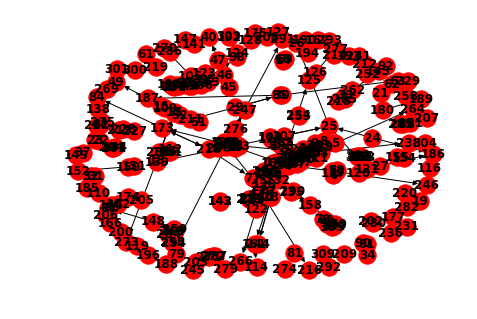

In [103]:
#plt.figure(figsize=(15, 10))
nx.draw(graph, with_labels=True, font_weight='bold')

In [5]:
def data_masks(all_usr_pois, item_tail):
    us_lens = [len(upois) for upois in all_usr_pois]
    len_max = max(us_lens)
    us_pois = [upois + item_tail * (len_max - le) for upois, le in zip(all_usr_pois, us_lens)]
    us_msks = [[1] * le + [0] * (len_max - le) for le in us_lens]
    return us_pois, us_msks, len_max

In [6]:
def split_validation(train_data, valid_rate):
    train_x, train_y = train_data
    n_samples = len(train_x)
    sidx = np.arange(n_samples, dtype='nt32')
    np.random.shuffle(sidx)
    n_train = int(np.round(n_samples*(1-valid_rate)))
    valid_x = [train_x[i] for i in sidx[n_train:]]
    valid_y = [train_y[i] for i in sidx[n_train:]]
    train_x = [train_x[i] for i in sidx[:n_train]]
    train_y = [train_y[i] for i in sidx[:n_train]]
    return (train_x, train_y), (valid_x, valid_y)

In [7]:
class Data():
    def __init__(self, data, sub_graph=False, method='ggnn', sparse=False, shuffle=False):
        inputs = data[0]
        inputs, mask, len_max = data_masks(inputs, [0])
        self.inputs = np.asarray(inputs)
        self.mask = np.asarray(mask)
        self.len_max = len_max
        self.targets = np.asarray(data[1])
        self.length = len(inputs)
        self.shuffle = shuffle
        self.sub_graph = sub_graph
        self.sparse = sparse
        self.method = method

    def generate_batch(self, batch_size):
        if self.shuffle:
            shuffled_arg = np.arange(self.length)
            np.random.shuffle(shuffled_arg)
            self.inputs = self.inputs[shuffled_arg]
            self.mask = self.mask[shuffled_arg]
            self.targets = self.targets[shuffled_arg]
        n_batch = int(self.length / batch_size)
        if self.length % batch_size != 0:
            n_batch += 1
        slices = np.split(np.arange(n_batch * batch_size), n_batch)
        slices[-1] = np.arange(self.length-batch_size, self.length)
        return slices

    def get_slice(self, index):   #这里将输入数据转换成为图的结构矩阵
        if 1:
            items, n_node, A_in, A_out, alias_inputs = [], [], [], [], []
            for u_input in self.inputs[index]:
                n_node.append(len(np.unique(u_input)))
            max_n_node = np.max(n_node)
            if self.method == 'ggnn':
                for u_input in self.inputs[index]:
                    node = np.unique(u_input)
                    items.append(node.tolist() + (max_n_node - len(node)) * [0])
                    u_A = np.zeros((max_n_node, max_n_node))
                    for i in np.arange(len(u_input) - 1):
                        if u_input[i + 1] == 0:
                            break
                        u = np.where(node == u_input[i])[0][0]
                        v = np.where(node == u_input[i + 1])[0][0]
                        u_A[u][v] = 1
                    u_sum_in = np.sum(u_A, 0)
                    u_sum_in[np.where(u_sum_in == 0)] = 1
                    u_A_in = np.divide(u_A, u_sum_in)
                    u_sum_out = np.sum(u_A, 1)
                    u_sum_out[np.where(u_sum_out == 0)] = 1
                    u_A_out = np.divide(u_A.transpose(), u_sum_out)

                    A_in.append(u_A_in)
                    A_out.append(u_A_out)
                    alias_inputs.append([np.where(node == i)[0][0] for i in u_input])
                return A_in, A_out, alias_inputs, items, self.mask[index], self.targets[index]
            elif self.method == 'gat':
                A_in = []
                A_out = []
                for u_input in self.inputs[index]:
                    node = np.unique(u_input)
                    items.append(node.tolist() + (max_n_node - len(node)) * [0])
                    u_A = np.eye(max_n_node)
                    for i in np.arange(len(u_input) - 1):
                        if u_input[i + 1] == 0:
                            break
                        u = np.where(node == u_input[i])[0][0]
                        v = np.where(node == u_input[i + 1])[0][0]
                        u_A[u][v] = 1
                    A_in.append(-1e9 * (1 - u_A))
                    A_out.append(-1e9 * (1 - u_A.transpose()))
                    alias_inputs.append([np.where(node == i)[0][0] for i in u_input])
                return A_in, A_out, alias_inputs, items, self.mask[index], self.targets[index]

        else:
            return self.inputs[index], self.mask[index], self.targets[index]

# build Model

In [8]:
import tensorflow as tf
import math

In [9]:
class Model(object):
    def __init__(self, hidden_size=100, out_size=100, batch_size=100, nonhybrid=True):
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.batch_size = batch_size
        self.mask = tf.placeholder(dtype=tf.float32)
        self.alias = tf.placeholder(dtype=tf.int32)  # 给给每个输入重新
        self.item = tf.placeholder(dtype=tf.int32)   # 重新编号的序列构成的矩阵
        self.tar = tf.placeholder(dtype=tf.int32)
        self.nonhybrid = nonhybrid
        self.stdv = 1.0 / math.sqrt(self.hidden_size)

        self.nasr_w1 = tf.get_variable('nasr_w1', [self.out_size, self.out_size], dtype=tf.float32,
                                       initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.nasr_w2 = tf.get_variable('nasr_w2', [self.out_size, self.out_size], dtype=tf.float32,
                                       initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.nasr_v = tf.get_variable('nasrv', [1, self.out_size], dtype=tf.float32,
                                      initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.nasr_b = tf.get_variable('nasr_b', [self.out_size], dtype=tf.float32, initializer=tf.zeros_initializer())

    def forward(self, re_embedding, train=True):
        rm = tf.reduce_sum(self.mask, 1)
        last_id = tf.gather_nd(self.alias, tf.stack([tf.range(self.batch_size), tf.to_int32(rm)-1], axis=1))
        last_h = tf.gather_nd(re_embedding, tf.stack([tf.range(self.batch_size), last_id], axis=1))
        seq_h = tf.stack([tf.nn.embedding_lookup(re_embedding[i], self.alias[i]) for i in range(self.batch_size)],
                         axis=0)                                                           #batch_size*T*d
        last = tf.matmul(last_h, self.nasr_w1)
        seq = tf.matmul(tf.reshape(seq_h, [-1, self.out_size]), self.nasr_w2)
        last = tf.reshape(last, [self.batch_size, 1, -1])
        m = tf.nn.sigmoid(last + tf.reshape(seq, [self.batch_size, -1, self.out_size]) + self.nasr_b)
        coef = tf.matmul(tf.reshape(m, [-1, self.out_size]), self.nasr_v, transpose_b=True) * tf.reshape(
            self.mask, [-1, 1])
        b = self.embedding[1:]
        if not self.nonhybrid:
            ma = tf.concat([tf.reduce_sum(tf.reshape(coef, [self.batch_size, -1, 1]) * seq_h, 1),
                            tf.reshape(last, [-1, self.out_size])], -1)
            self.B = tf.get_variable('B', [2 * self.out_size, self.out_size],
                                     initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
            y1 = tf.matmul(ma, self.B)
            logits = tf.matmul(y1, b, transpose_b=True)
        else:
            ma = tf.reduce_sum(tf.reshape(coef, [self.batch_size, -1, 1]) * seq_h, 1)
            logits = tf.matmul(ma, b, transpose_b=True)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.tar - 1, logits=logits))
        self.vars = tf.trainable_variables()
        if train:
            lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in self.vars if v.name not
                               in ['bias', 'gamma', 'b', 'g', 'beta']]) * self.L2
            loss = loss + lossL2
        return loss, logits

    def run(self, fetches, tar, item, adj_in, adj_out, alias, mask):
        return self.sess.run(fetches, feed_dict={self.tar: tar, self.item: item, self.adj_in: adj_in,
                                                 self.adj_out: adj_out, self.alias: alias, self.mask: mask})


class GGNN(Model):
    def __init__(self,hidden_size=100, out_size=100, batch_size=300, n_node=None,
                 lr=None, l2=None, step=1, decay=None, lr_dc=0.1, nonhybrid=False):
        super(GGNN,self).__init__(hidden_size, out_size, batch_size, nonhybrid)
        self.embedding = tf.get_variable(shape=[n_node, hidden_size], name='embedding', dtype=tf.float32,
                                         initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.adj_in = tf.placeholder(dtype=tf.float32, shape=[self.batch_size, None, None])
        self.adj_out = tf.placeholder(dtype=tf.float32, shape=[self.batch_size, None, None])
        self.n_node = n_node
        self.L2 = l2
        self.step = step
        self.nonhybrid = nonhybrid
        self.W_in = tf.get_variable('W_in', shape=[self.out_size, self.out_size], dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.b_in = tf.get_variable('b_in', [self.out_size], dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.W_out = tf.get_variable('W_out', [self.out_size, self.out_size], dtype=tf.float32,
                                     initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        self.b_out = tf.get_variable('b_out', [self.out_size], dtype=tf.float32,
                                     initializer=tf.random_uniform_initializer(-self.stdv, self.stdv))
        with tf.variable_scope('ggnn_model', reuse=None):
            self.loss_train, _ = self.forward(self.ggnn())
        with tf.variable_scope('ggnn_model', reuse=True):
            self.loss_test, self.score_test = self.forward(self.ggnn(), train=False)
        self.global_step = tf.Variable(0)
        self.learning_rate = tf.train.exponential_decay(lr, global_step=self.global_step, decay_steps=decay,
                                                        decay_rate=lr_dc, staircase=True)
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_train, global_step=self.global_step)
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
        config = tf.ConfigProto(gpu_options=gpu_options)
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())

    def ggnn(self):
        fin_state = tf.nn.embedding_lookup(self.embedding, self.item)
        cell = tf.nn.rnn_cell.GRUCell(self.out_size)
        with tf.variable_scope('gru'):
            for i in range(self.step):
                fin_state = tf.reshape(fin_state, [self.batch_size, -1, self.out_size])
                fin_state_in = tf.reshape(tf.matmul(tf.reshape(fin_state, [-1, self.out_size]),
                                                    self.W_in) + self.b_in, [self.batch_size, -1, self.out_size])
                fin_state_out = tf.reshape(tf.matmul(tf.reshape(fin_state, [-1, self.out_size]),
                                                     self.W_out) + self.b_out, [self.batch_size, -1, self.out_size])
                av = tf.concat([tf.matmul(self.adj_in, fin_state_in),
                                tf.matmul(self.adj_out, fin_state_out)], axis=-1)
                state_output, fin_state = \
                    tf.nn.dynamic_rnn(cell, tf.expand_dims(tf.reshape(av, [-1, 2*self.out_size]), axis=1),
                                      initial_state=tf.reshape(fin_state, [-1, self.out_size]))
        return tf.reshape(fin_state, [self.batch_size, -1, self.out_size])

In [10]:
train_data = Data(train, sub_graph=True, method='ggnn', shuffle=True)
test_data = Data(test, sub_graph=True, method='ggnn', shuffle=False)

In [11]:
len(set(sum(train[0],[])))

304

In [12]:
model = GGNN(hidden_size=100, out_size=100, batch_size=100, n_node=310,
                 lr=0.001, l2=1e-5,  step=1, decay=3 * len(train_data.inputs) /100, lr_dc=0.1,
                 nonhybrid='store_true')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


/home/dsq/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
best_result = [0, 0]
best_epoch = [0, 0]
for epoch in range(30):
    print('epoch: ', epoch, '===========================================')
    slices = train_data.generate_batch(model.batch_size)
    fetches = [model.opt, model.loss_train, model.global_step]
    print('start training: ', datetime.datetime.now())
    loss_ = []
    for i, j in zip(slices, np.arange(len(slices))):
        adj_in, adj_out, alias, item, mask, targets = train_data.get_slice(i)
        _, loss, _ = model.run(fetches, targets, item, adj_in, adj_out, alias,  mask)
        loss_.append(loss)
    loss = np.mean(loss_)
    slices = test_data.generate_batch(model.batch_size)
    print('start predicting: ', datetime.datetime.now())
    hit, mrr, test_loss_ = [], [],[]
    for i, j in zip(slices, np.arange(len(slices))):
        adj_in, adj_out, alias, item, mask, targets = test_data.get_slice(i)
        scores, test_loss = model.run([model.score_test, model.loss_test], targets, item, adj_in, adj_out, alias,  mask)
        test_loss_.append(test_loss)
        index = np.argsort(scores, 1)[:, -20:]
        for score, target in zip(index, targets):
            hit.append(np.isin(target - 1, score))
            if len(np.where(score == target - 1)[0]) == 0:
                mrr.append(0)
            else:
                mrr.append(1 / (20-np.where(score == target - 1)[0][0]))
    hit = np.mean(hit)*100
    mrr = np.mean(mrr)*100
    test_loss = np.mean(test_loss_)
    if hit >= best_result[0]:
        best_result[0] = hit
        best_epoch[0] = epoch
    if mrr >= best_result[1]:
        best_result[1] = mrr
        best_epoch[1]=epoch
    print('train_loss:\t%.4f\ttest_loss:\t%4f\tRecall@20:\t%.4f\tMMR@20:\t%.4f\tEpoch:\t%d,\t%d'%
          (loss, test_loss, best_result[0], best_result[1], best_epoch[0], best_epoch[1]))

epoch:  0 ===========================================
start training:  2019-08-08 17:15:34.668564
start predicting:  2019-08-08 17:15:36.350835
train_loss:	5.5779	test_loss:	5.355560	Recall@20:	69.6923	MMR@20:	53.8532	Epoch:	0,	0
epoch:  1 ===========================================
start training:  2019-08-08 17:15:36.964836
start predicting:  2019-08-08 17:15:37.321285
train_loss:	5.0737	test_loss:	4.660647	Recall@20:	74.5385	MMR@20:	55.7632	Epoch:	1,	1
epoch:  2 ===========================================
start training:  2019-08-08 17:15:37.645170
start predicting:  2019-08-08 17:15:37.997921
train_loss:	4.4019	test_loss:	4.082599	Recall@20:	79.3846	MMR@20:	57.9117	Epoch:	2,	2
epoch:  3 ===========================================
start training:  2019-08-08 17:15:38.300027
start predicting:  2019-08-08 17:15:38.642731
train_loss:	4.0816	test_loss:	4.022038	Recall@20:	80.4615	MMR@20:	58.1990	Epoch:	3,	3
epoch:  4 ===========================================
start training:  2019-08-0

In [ ]:
model.predict